In [1]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.cnnlstm import CNNLSTMModel
from src.training_utils import *
from src.tuning_utils import *
import optuna

In [2]:
# define data directory
data_dir = '../data/'

In [3]:
# load data
data = load_data(data_dir)

# split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

Number of samples: 13388
--------------------
Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)
--------------------
X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

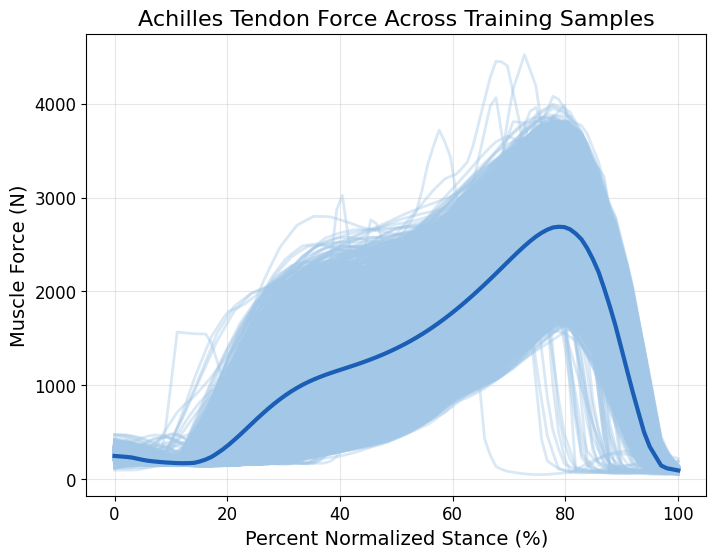

In [4]:
# plot data to double check
plot_achilles_force(y_train)

In [5]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [6]:
# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [7]:
def objective(trial, train_dataset, val_dataset, device):
    """
    Optuna objective function for hyperparameter optimization.
    
    Args:
        trial: Optuna trial object.
        train_dataset: Training dataset.
        val_dataset: Validation dataset.
        device: Device to use for training.
    
    Returns:
        float: Best validation loss for this trial.
    """
    # Sample hyperparameters
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 3, step=1)
    dropout = trial.suggest_float('dropout', 0.0, 0.5, log=False)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    regularization = trial.suggest_float('regularization', 1e-5, 1e-2, log=True)
    
    # Prepare model parameters
    model_params = {
        'input_size': 3,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'output_size': 9,
        'dropout': dropout
    }
    
    # Train and evaluate
    best_val_loss, _ = train_eval_optuna(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        model_class=CNNLSTMModel,
        model_params=model_params,
        learning_rate=learning_rate,
        batch_size=batch_size,
        regularization=regularization,
        device=device,
        num_epochs=500,
        patience=10,
        verbose=False
    )
    
    return best_val_loss


# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(trial, train_dataset, val_dataset, device),
    n_trials=100
)

print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)

[I 2025-12-04 22:32:27,897] A new study created in memory with name: no-name-67cc2f2c-34b5-4f0b-8d27-7ef1f0f01d44
[I 2025-12-04 22:36:52,002] Trial 0 finished with value: 15632.137863181988 and parameters: {'hidden_size': 32, 'num_layers': 3, 'dropout': 0.4666644119517944, 'learning_rate': 0.0022702395043401116, 'batch_size': 32, 'regularization': 0.0010790644865477145}. Best is trial 0 with value: 15632.137863181988.
[I 2025-12-04 22:52:15,375] Trial 1 finished with value: 180554.68567825112 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.2951832171408574, 'learning_rate': 1.5443556706564556e-05, 'batch_size': 32, 'regularization': 0.005136388931688134}. Best is trial 0 with value: 15632.137863181988.
[I 2025-12-04 22:57:15,082] Trial 2 finished with value: 1857.6026854009015 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4286001974573471, 'learning_rate': 0.0008899210465714066, 'batch_size': 64, 'regularization': 0.004759879013093896}. Best is tr

Best hyperparameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.11192179432694598, 'learning_rate': 0.0002087759778164255, 'batch_size': 32, 'regularization': 6.285431401523002e-05}
Best validation loss: 1429.4851141731478


In [8]:
# Create test dataset
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [9]:
# Train the final model with the best hyperparameters
best_model, results = train_final_model(
    train_dataset=train_dataset, 
    val_dataset=val_dataset,
    test_dataset=test_dataset, 
    model_class=CNNLSTMModel,
    best_params=study.best_params,
    device=device,
    num_epochs=1000,
    patience=20,
    save_path='../models/cnn-lstm_v2.pth'
)

Training final model with best hyperparameters:
hidden_size: 256
num_layers: 3
dropout: 0.11192179432694598
learning_rate: 0.0002087759778164255
batch_size: 32
regularization: 6.285431401523002e-05
Epoch [10/1000], Train Loss: 217248.2096, Val Loss: 215467.5512
Epoch [20/1000], Train Loss: 178768.4504, Val Loss: 177032.3419
Epoch [30/1000], Train Loss: 145364.3228, Val Loss: 144275.7976
Epoch [40/1000], Train Loss: 116996.3475, Val Loss: 116119.5728
Epoch [50/1000], Train Loss: 92833.8382, Val Loss: 92181.2778
Epoch [60/1000], Train Loss: 72532.5685, Val Loss: 72045.6067
Epoch [70/1000], Train Loss: 55684.5749, Val Loss: 55400.0095
Epoch [80/1000], Train Loss: 42017.5319, Val Loss: 42000.6280
Epoch [90/1000], Train Loss: 31096.3957, Val Loss: 31119.4044
Epoch [100/1000], Train Loss: 22539.9241, Val Loss: 22732.6572
Epoch [110/1000], Train Loss: 15981.4069, Val Loss: 16321.2771
Epoch [120/1000], Train Loss: 11078.1382, Val Loss: 11405.3773
Epoch [130/1000], Train Loss: 7462.1591, Val Lo

In [10]:
# Test the model and get predictions for plotting
criterion = nn.MSELoss()
test_loss, test_outputs, test_targets = test_final_model(
    model=best_model,
    test_dataset=test_dataset,
    batch_size=study.best_params['batch_size'],
    criterion=criterion,
    device=device
    )

Final Model Results:
Test Loss:       1389.380936


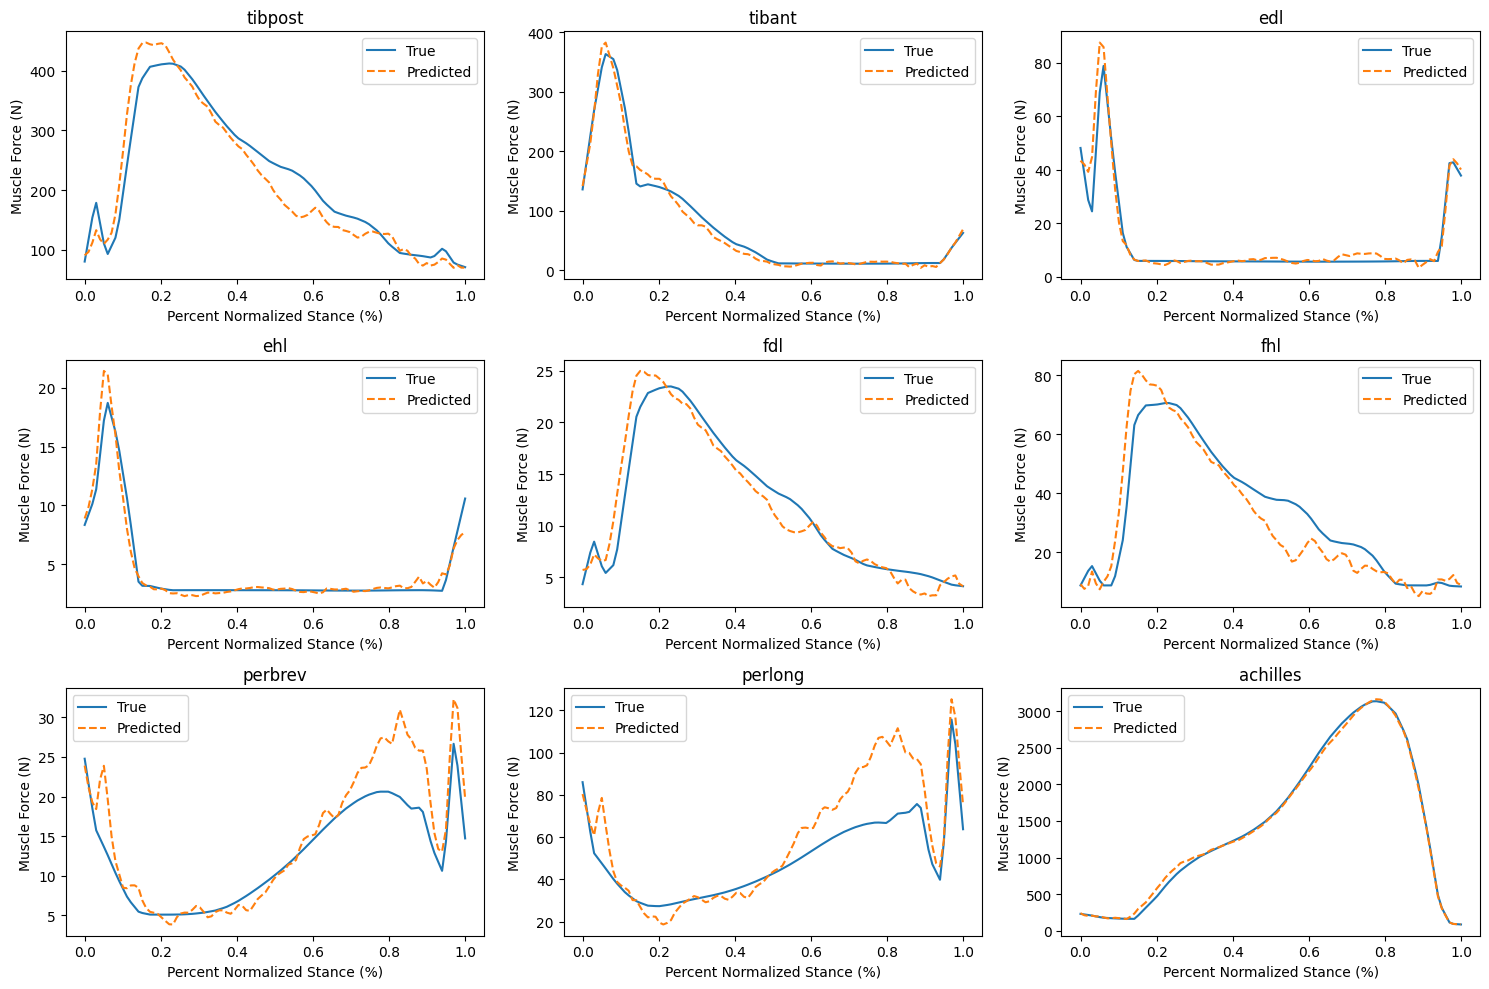

In [11]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)